In [1]:
import matplotlib.pyplot as plt
import pandas as pd
from lmfit import Model
import numpy as np

In [2]:
# read the kinetic results obtained at specific concentration e.g., 0.17335 mg/mL
df = pd.read_csv('Co_10%.csv')

# define x: minutes and y: Ct/C0 column
xData = df.loc[:, 'x']
yData = df.loc[:, 'y']

In [3]:
C0 = 0.17335 # intial concentration at [mg/mL]
h = 2 # bed height at [cm] 
r = 0.9 # bed diameter at [cm]
A = np.pi*(r**2)*h # cross-section area at [cm^2]
Q = 100 # total flow rate at [mL/min]
v = Q/A
W = 1 # adsorbent weight at [g]

In [4]:
# fitting function Thomas
def Thomas(x, kTH, qe):
    return 1/(1 + np.exp(kTH*qe*(W/Q) - kTH*C0*x))

my_model = Model(Thomas)
my_model.set_param_hint('kTH', min=0, max=100)
my_model.set_param_hint('qe', min=0, max=200)

result_Thomas = my_model.fit(yData, x=xData, kTH=8, qe=50)

x_eval = np.linspace(min(xData), max(xData), 200)

best_values = result_Thomas.best_values
best_fit = result_Thomas.best_fit
best_Thomas = np.array(Thomas(x_eval, best_values['kTH'], best_values['qe']))

print(result_Thomas.fit_report())

[[Model]]
    Model(Thomas)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 31
    # data points      = 1655
    # variables        = 2
    chi-square         = 0.83921588
    reduced chi-square = 5.0769e-04
    Akaike info crit   = -12552.2261
    Bayesian info crit = -12541.4030
[[Variables]]
    kTH:  2.77961762 +/- 0.01783941 (0.64%) (init = 8)
    qe:   194.798580 +/- 0.26202932 (0.13%) (init = 50)


In [5]:
# fitting function Yoon-Nelson
def Yoon_Nelson(x, kYN, tau):
    return np.exp(kYN*(x-tau))/(1+np.exp(kYN*(x-tau)))

my_model = Model(Yoon_Nelson)
my_model.set_param_hint('kYN', min=0, max=100)
my_model.set_param_hint('tau', min=0, max=200)

result_Yoon_Nelson = my_model.fit(yData, x=xData, kYN=1, tau=10)

x_eval = np.linspace(min(xData), max(xData), 200)

best_values = result_Yoon_Nelson.best_values
best_fit = result_Yoon_Nelson.best_fit
best_Yoon_Nelson = np.array(Yoon_Nelson(x_eval, best_values['kYN'], best_values['tau']))

print(result_Yoon_Nelson.fit_report())

[[Model]]
    Model(Yoon_Nelson)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 22
    # data points      = 1655
    # variables        = 2
    chi-square         = 0.83921588
    reduced chi-square = 5.0769e-04
    Akaike info crit   = -12552.2261
    Bayesian info crit = -12541.4030
[[Variables]]
    kYN:  0.48184358 +/- 0.00309244 (0.64%) (init = 1)
    tau:  11.2373001 +/- 0.01511599 (0.13%) (init = 10)


In [6]:
# fitting function Adams_Bohart - we only consider the initial state of adsorption process at Ct/C0 ~ 5-10%
new_df = df[df['y'] <= 0.10]

xData2 = new_df.loc[:, 'x']
yData2 = new_df.loc[:, 'y']

def Adams_Bohart(x, kAB, N0):
    return np.exp(kAB*C0*x - kAB*N0*(h/v))

my_model = Model(Adams_Bohart)
my_model.set_param_hint('kAB', min=0, max=100)
my_model.set_param_hint('N0', min=0, max=100)

result_Adams_Bohart = my_model.fit(yData2, x=xData2, kAB=8, N0=11)

x_eval2 = np.linspace(min(xData2), max(xData2), 200)

best_values = result_Adams_Bohart.best_values
best_fit = result_Adams_Bohart.best_fit
best_Adams_Bohart = np.array(Adams_Bohart(x_eval2, best_values['kAB'], best_values['N0']))

print(result_Adams_Bohart.fit_report())

[[Model]]
    Model(Adams_Bohart)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 28
    # data points      = 211
    # variables        = 2
    chi-square         = 1.7813e-04
    reduced chi-square = 8.5228e-07
    Akaike info crit   = -2946.80752
    Bayesian info crit = -2940.10380
[[Variables]]
    kAB:  6.13712206 +/- 0.03012569 (0.49%) (init = 8)
    N0:   16.5742144 +/- 0.02204303 (0.13%) (init = 11)
[[Correlations]] (unreported correlations are < 0.100)
    C(kAB, N0) = -0.984


<bound method Figure.tight_layout of <Figure size 900x600 with 1 Axes>>

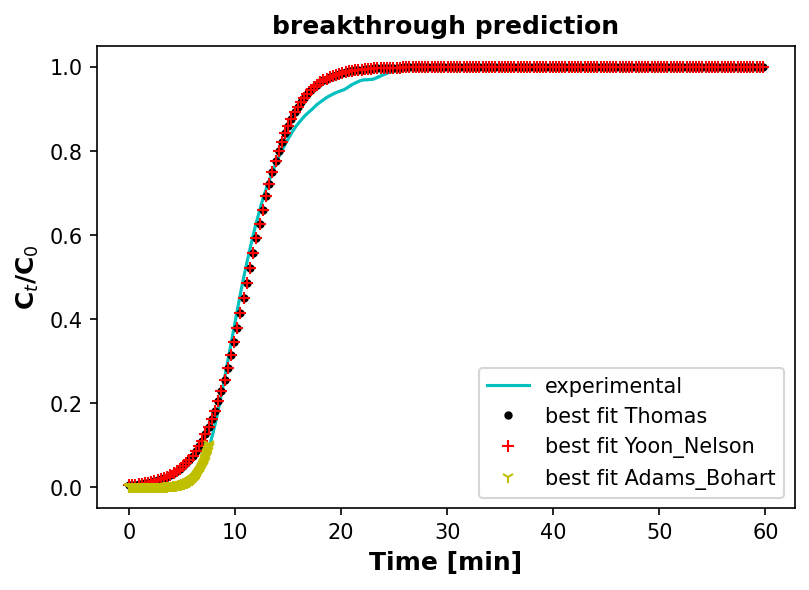

In [7]:
# define the size of the figure
fig, ax = plt.subplots(figsize=(6,4), dpi=150)

# plot experimental data
ax.plot(xData, yData, "c", label='experimental', markersize=1)
ax.plot(x_eval, best_Thomas, 'k.', mfc=None, label='best fit Thomas', linewidth = 1)
ax.plot(x_eval, best_Yoon_Nelson, 'r+', label='best fit Yoon_Nelson', linewidth = 1)
ax.plot(x_eval2, best_Adams_Bohart, 'y1', mfc=None, label='best fit Adams_Bohart', linewidth = 1)

# edit plot
ax.set_xlabel("Time [min]", fontsize=12, fontweight='bold')
ax.set_ylabel("C$_t$/C$_0$", fontsize=12, fontweight='bold')
ax.set_title('breakthrough prediction', fontsize=12, fontweight='bold', loc = 'center')
ax.legend()
fig.tight_layout

In [8]:
aic_df = pd.DataFrame({'model':['Thomas', 'Yoon_Nelson', 'Adams_Bohart'],
                       'aic':[result_Thomas.aic, result_Yoon_Nelson.aic, result_Adams_Bohart.aic]})


aic_df.sort_values('aic')
aic_df

,model,aic
0,Thomas,-12552.226144
1,Yoon_Nelson,-12552.226143
2,Adams_Bohart,-2946.807515
